Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

## Some notes for Word2Vec 
(from [Tensorflow's tutorial](https://www.tensorflow.org/tutorials/word2vec) )
- In traditional NLP methods, words are represented with discrete atomic symbols where similar words can have little connection with each other. This representation leads to sparse data which is not good for training the model. And this can be improved via using vector representations.
- Vector space models (VSMs) represent (or embed) words in a continuous vector space where semantically similar words tend to be mapped to nearby points.

- There are 2 major methods for Word2Vec. One is Continuous Bag-of-Words model(CBOW), another is Skip-Gram model. 
       Their major difference:
       CBOW predicts target words from source context words,
       Skip-Gram predicts source context words from the target words

- For training, Word2Vec uses maximum likehood principle to maximize the probability of the target word $w_{t}$ given the previous words h(history or context). However, training on this objective requires to run through **all other words $w^{'}$ in the current context h at every training step**, which is too expensive. Instead of looking at all other words, both CBOW and Skip-Gram models select k imaginary(noise) words $\widetilde{w}$ from the same context and then try to discriminate the real target words $w_{t}$ from these k noise words.

### Related tensorflow functions to check
- [tf.nn.embedding_lookup](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup)
- [tf.nn.sampled_softmax_loss](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss)

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
# we only consider the 50,000 most common words, and regard others as unknown (rare words)
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5236, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


data: the index of each word in words
count: the counter of all words
dictionary:

Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  # make it global, so that data_index can be used during multiple call of generate_batch
  global data_index 
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span) # buffer is a deque, with length of span
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data) # loop back to beginning of words if reach the end
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid: # loop until get a valid new target
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target) # the element at the head will be 
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print(batch, batch.shape)
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print(labels, labels.shape)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
[3084 3084   12   12    6    6  195  195] (8,)
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']
[[  12]
 [5236]
 [3084]
 [   6]
 [  12]
 [ 195]
 [   2]
 [   6]] (8, 1)

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
[12 12 12 12  6  6  6  6] (8,)
    labels: ['a', 'originated', 'term', 'anarchism', 'term', 'as', 'originated', 'of']
[[   6]
 [3084]
 [ 195]
 [5236]
 [ 195]
 [  12]
 [3084]
 [   2]] (8, 1)


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset) 
  # embed.shape should be: batch_size x embedding_size, here it's 128 x 128
  # Compute the softmax loss, using a sample of the negative labels each time (the imaginary (noise) words
  # as described in the notes at the beginning of this notebook).
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size), 
                               name='sampled_softmax_loss')
  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset) # shape : (16, 128)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) 
    # similarity (16, 128) * (128, 50000) = (16, 50000), the similarity between valid words 
    # and all other 50000 words in our dataset (including UNK)           

In [7]:
print(valid_examples) # 16 random numbers from 0 to 99
print(similarity.shape)

[87 80 95 30 58 36 53 68 70 42 65 34 13 96 61 60]
(16, 50000)


In [8]:
num_steps = 20001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.310068
Nearest to known: calorie, alert, machado, pennant, waxy, blender, chancery, americas,
Nearest to over: fusion, solace, flapping, centering, bibliographical, heroines, yule, connectors,
Nearest to so: ethiopic, freeview, handheld, persist, doubleday, zarathustra, pods, alphege,
Nearest to his: past, backside, alo, homographs, scrabble, astrolabe, preamble, funded,
Nearest to new: wmap, porgy, tortoise, beach, ship, vocalists, adams, lateran,
Nearest to he: collie, adopting, cir, heizei, julia, realizes, clive, rainwater,
Nearest to can: drugged, mineralogical, mise, hjalmar, attest, conversation, blogger, tiki,
Nearest to see: disbandment, prevented, gateless, emancipated, enforce, chunks, senegal, chord,
Nearest to than: respondents, sickle, repeatable, bj, enjoyment, financiers, undoubtedly, victoriae,
Nearest to but: glans, arterial, missions, clerical, halifax, derivations, bulge, starter,
Nearest to time: mycobacterium, proven, valuable

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
print(two_d_embeddings.shape)

(400, 2)


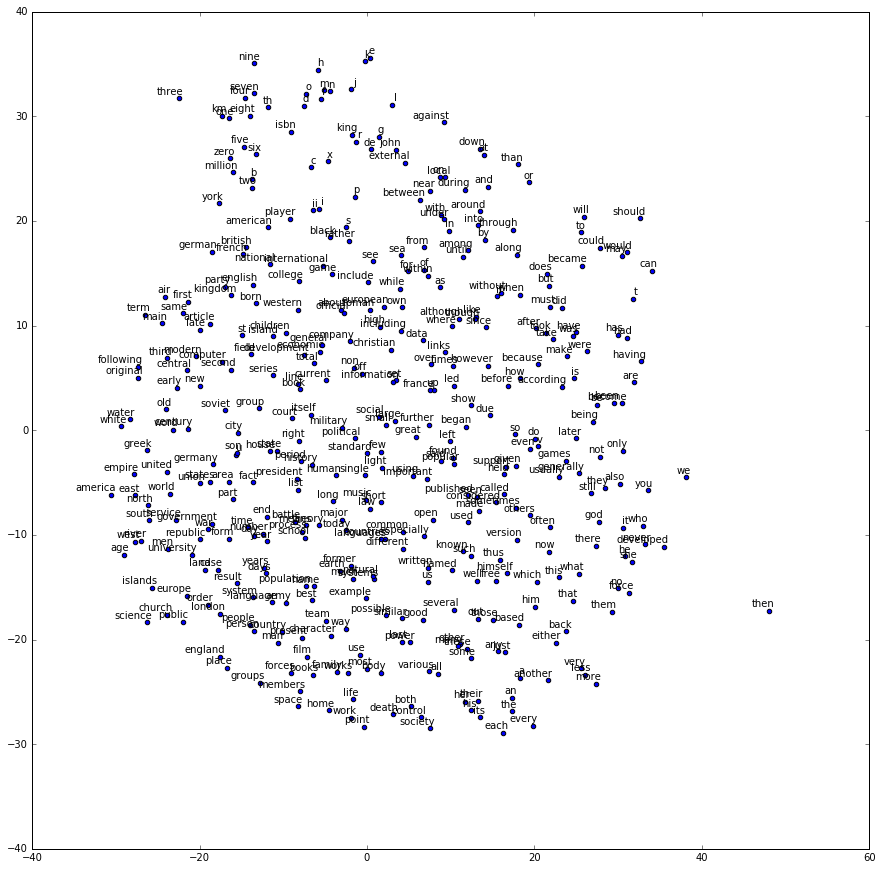

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]  # 1x2 vector
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

The major difference of CBOW compared with skip-gram is the content of training data and labels. In CBOW, the model tries to **predict the target word from the context**(or history, i.e. the windows of words near the target word). Thus the training data consists of words in the context and the labels contain target words.

In [16]:
data_index = 0

def generate_CBOW_batch(batch_size, bag_window):
  # make it global, so that data_index can be used during multiple call of generate_batch
  global data_index 
  span = 2 * bag_window + 1 # [ bag_window target bag_window ] use bag windows to predict target
  batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32) # length of context is span-1
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  buffer = collections.deque(maxlen=span) # buffer is a deque, with length of span
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data) # loop back to beginning of words if reach the end
  
  # In the context with length span, buffer[bag_window] is always the central word (i.e. the target word)
  for i in range(batch_size):
    # for each target word, form a list of its context words (with length span-1 = 2 * bag_window)
    for j in range(1, bag_window + 1):
        batch[i, (j-1) * bag_window] = buffer[bag_window - j]
        batch[i, (j-1) * bag_window + 1] = buffer[bag_window + j]
    labels[i, 0] = buffer[bag_window]
    buffer.append(data[data_index]) 
    # append one word at the tail of dequeue, the word at head is automatically dropped
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_CBOW_batch(batch_size=4, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [ [reverse_dictionary[bi] for bi in bis] for bis in batch])
    print(batch, batch.shape)
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])
    print(labels, labels.shape)

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
[[5236   12]
 [3084    6]
 [  12  195]
 [   6    2]] (4, 2)
    labels: ['originated', 'as', 'a', 'term']
[[3084]
 [  12]
 [   6]
 [ 195]] (4, 1)

with bag_window = 2:
    batch: [['originated', 'a', 'anarchism', 'term'], ['as', 'term', 'originated', 'of'], ['a', 'of', 'as', 'abuse'], ['term', 'abuse', 'a', 'first']]
[[3084    6 5236  195]
 [  12  195 3084    2]
 [   6    2   12 3137]
 [ 195 3137    6   46]] (4, 4)
    labels: ['as', 'a', 'term', 'of']
[[ 12]
 [  6]
 [195]
 [  2]] (4, 1)


After modifying the batch and labels for CBOW, the training part is **almost the same as that of skip-gram model**. We only need to change the shape of train_dataset and train_labels according to our training batch_size.

** Another important change is for the computation of softmax_loss**. Since the shape of our softmax_weights and softmax_biases are unchanged (for weights it's still [vocabulary_size, embedding_size]), we must adapt the shape of our embed. Now our embed has the shape of batch_size x (bag_window\*2) x embedding_size, we should make it batch_size x embedding_size. Thus we can simply sum over the second dimension **using tf.reduce_sum(embed, axis=1) or tf.reduce_mean(embed, 1)** - This simply add the vectors of context words in our vector space. 

In [20]:
batch_size = 128
bag_window = 2
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset) 
  # embed.shape should be: batch_size x embedding_size, here it's 128 x (bag_window*2) x 128 
  # note: embedding_lookup returns Tensor with shape of: shape(ids) + shape(embeddings)[1:]
  # Compute the softmax loss, using a sample of the negative labels each time (the imaginary (noise) words
  # as described in the notes at the beginning of this notebook).
  
  # The difference is that we should sum over the second dimension (sum over all bag_windows*2 elements)
  loss = tf.reduce_mean(
     tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=tf.reduce_mean(embed, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size), 
                               name='sampled_softmax_loss')

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset) # shape : (16, 128)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings)) 
    # similarity (16, 128) * (128, 50000) = (16, 50000), the similarity between valid words 
    # and all other 50000 words in our dataset (including UNK)           

In [21]:
num_steps = 40001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_CBOW_batch(
      batch_size, bag_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.642972
Nearest to been: glossolalia, imperfectly, redistribute, peculiarly, longsword, fulton, triage, validly,
Nearest to but: witwatersrand, municipal, insights, statuary, market, ansible, gobi, melcher,
Nearest to in: boiling, melos, offender, crespigny, cnn, event, cloudbusting, cohomology,
Nearest to two: brides, pirin, shards, null, mpd, emiliano, gazette, among,
Nearest to six: glasses, purim, firefly, tha, hypomanic, remarks, affluent, blazing,
Nearest to to: flowering, dkw, indra, stereo, truncation, styling, vanity, lakoff,
Nearest to at: amer, concentric, ducas, hobbies, irritating, clemens, embassy, shebaa,
Nearest to history: uninteresting, alto, ayla, devastates, divina, erv, zondervan, lesotho,
Nearest to if: mentored, dept, overlapped, viridis, bolstering, summary, carcass, messe,
Nearest to he: polka, acre, afghani, abidjan, control, absolutism, prolong, statement,
Nearest to known: dinger, gyroscopic, gehrig, ischemic, chickenpox,

(400, 2)


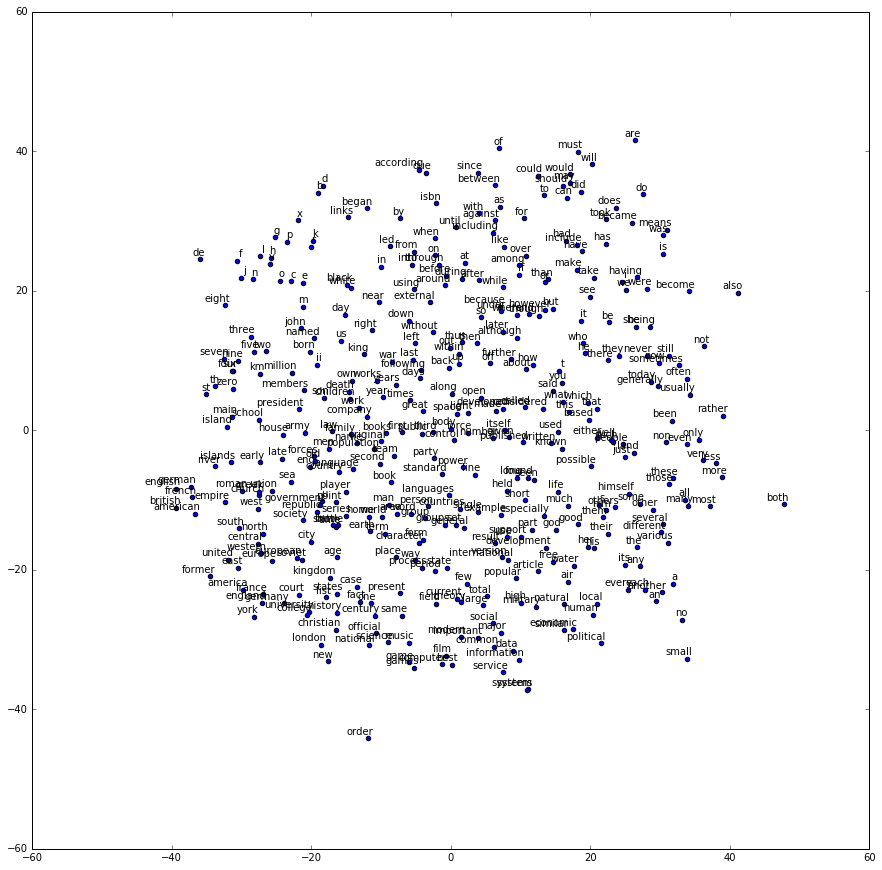

In [22]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
print(two_d_embeddings.shape)

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]  # 1x2 vector
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)